# 1. Original Model

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
from paths import names

In [ ]:
# read in all the words
words = open(names, "r").read().splitlines()
print(len(words))
print(words[:8])

32033
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [122]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [47]:
# shuffle the words
import random
random.shuffle(words)

In [124]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182778, 3]) torch.Size([182778])
torch.Size([22633, 3]) torch.Size([22633])
torch.Size([22735, 3]) torch.Size([22735])


In [125]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print("".join([itos[int(ix.item())] for ix in x]), "-->", itos[int(y.item())])

... --> e
..e --> m
.em --> m
emm --> a
mma --> .
... --> o
..o --> l
.ol --> i
oli --> v
liv --> i
ivi --> a
via --> .
... --> a
..a --> v
.av --> a
ava --> .
... --> i
..i --> s
.is --> a
isa --> b


In [10]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), ) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [53]:
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

C = torch.randn(
    (vocab_size, n_embd),
)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

22097


In [12]:
# same optimization as last time
max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), )
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < max_steps*0.75 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % (max_steps/8) == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/  20000: 3.3009
   2500/  20000: 2.3652
   5000/  20000: 2.0153
   7500/  20000: 2.2790
  10000/  20000: 2.1316
  12500/  20000: 2.3740
  15000/  20000: 1.8734
  17500/  20000: 2.0956


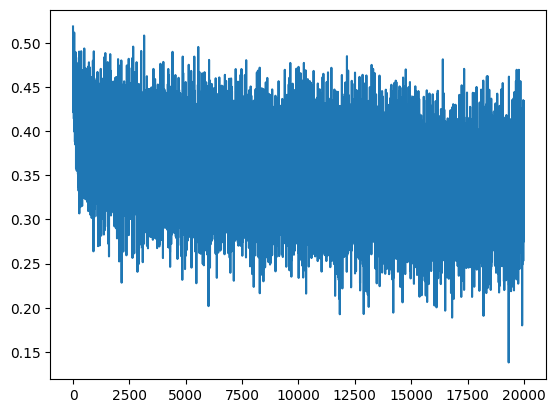

In [13]:
plt.plot(lossi)

In [14]:
# put layers into eval mode
for layer in layers:
    layer.training = False

In [15]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())


split_loss('train')
split_loss('val')

train 2.1562631130218506
val 2.1673715114593506


# 2. Improving code

## 2.1 Nicer loss plot

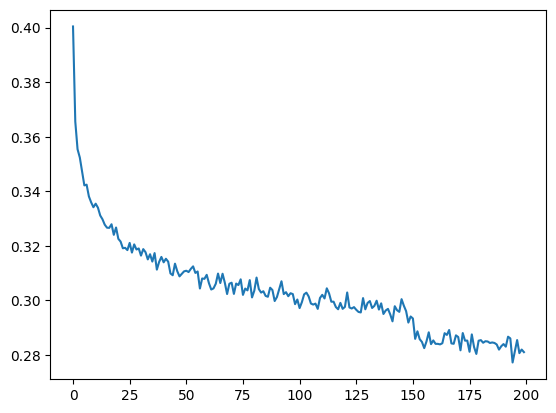

In [262]:
plt.plot(torch.tensor(lossi).view(-1, int(max_steps/200)).mean(1))

## 2.2 Putting everything into layers

In [74]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = (
            torch.randn(
                (fan_in, fan_out),
            )
            / fan_in**0.5
        )
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)  # batch mean
            xvar = x.var(0, keepdim=True)  # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * xmean
                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []


class Sequential:
    def __init__(self,layers):
        self.layers = layers

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
            self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [75]:
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP
vocab_size = len(itos)


model  = Sequential( [
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

22097


In [77]:
# same optimization as last time
max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(
        0,
        Xtr.shape[0],
        (batch_size,),
    )
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < max_steps * 0.75 else 0.01  # step learning rate decay

    #lr = 0.1
    #if i % (max_steps / 4) == 0:
        #lr = lr * 0.7


    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % (max_steps / 8) == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())


      0/ 100000: 2.4389
  12500/ 100000: 2.4106
  25000/ 100000: 2.1671
  37500/ 100000: 2.1049
  50000/ 100000: 1.7503
  62500/ 100000: 2.2216
  75000/ 100000: 2.2383
  87500/ 100000: 1.8447


In [260]:
# put layers into eval mode
for layer in model.layers:
    layer.training = False

In [261]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 1.9036978483200073
val 2.248166084289551


## 2.3 Making wavenet

In [126]:
# build the dataset
block_size = (
    8  # context length: how many characters do we take to predict the next one?
)

Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])  # 10%

torch.Size([182778, 8]) torch.Size([182778])
torch.Size([22633, 8]) torch.Size([22633])
torch.Size([22735, 8]) torch.Size([22735])


In [127]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print("".join([itos[int(ix.item())] for ix in x]), "-->", itos[int(y.item())])

........ --> e
.......e --> m
......em --> m
.....emm --> a
....emma --> .
........ --> o
.......o --> l
......ol --> i
.....oli --> v
....oliv --> i
...olivi --> a
..olivia --> .
........ --> a
.......a --> v
......av --> a
.....ava --> .
........ --> i
.......i --> s
......is --> a
.....isa --> b


Scratchspace to experiment

In [128]:
model.layers[0].out.shape

torch.Size([4, 8, 10])

In [131]:
model.layers[1].out.shape

torch.Size([4, 8, 10])

In [140]:
model.layers[2].out.shape

torch.Size([4, 4, 200])

Instead of processing all 8 examples at once we want to process 4 chunks of 2.

In [254]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = (
            torch.randn(
                (fan_in, fan_out),
            )
            / fan_in**0.5
        )
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# my code

# yay


class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim ==2:
                dim = 0
            elif x.ndim ==3:
                dim = (0,1)

            xmean = x.mean(dim, keepdim=True)  # batch mean
            xvar = x.var(dim, keepdim=True)  # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * xmean
                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]


class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
            self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


class FlattenConsecutive:

    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        (
            B,
            T,
            C,
        ) = x.shape
        x = x.view(B, T // self.n, C * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []

In [255]:
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 68  # the number of neurons in the hidden layer of the MLP
vocab_size = len(itos)


model = Sequential(
    [
        Embedding(vocab_size, n_embd),
        FlattenConsecutive(2),
        Linear(2 * n_embd, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        FlattenConsecutive(2),
        Linear(2 * n_hidden, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        FlattenConsecutive(2),
        Linear(2 * n_hidden, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        Linear(n_hidden, vocab_size),
    ]
)




with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

22397


In [250]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0, 16, 18, 15, 13, 25, 19,  5],
        [ 0,  0,  0,  0,  0,  0,  1,  1],
        [ 0, 13,  1, 18, 12,  9, 25,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0]])

In [257]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)


In [256]:
# same optimization as last time
max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(
        0,
        Xtr.shape[0],
        (batch_size,),
    )
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < max_steps * 0.75 else 0.01  # step learning rate decay

    # lr = 0.1
    # if i % (max_steps / 4) == 0:
    # lr = lr * 0.7

    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % (max_steps / 8) == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 100000: 3.5206
  12500/ 100000: 2.2136
  25000/ 100000: 1.7079
  37500/ 100000: 1.8897
  50000/ 100000: 2.2692
  62500/ 100000: 2.1623
  75000/ 100000: 2.2223
  87500/ 100000: 1.8294


# 4. Performance log


Original model
- train 2.080084800720215
- val 2.1164207458496094

First try at improving learning rate
- train 2.1453757286071777
- val 2.178053379058838

With 8 charachters of context and normal lr again
- train 1.9414528608322144
- val 2.0188820362091064




hira
train 1.9280579090118408
val 2.2608351707458496

# 5. Sampling from the model

In [86]:
# sample from the model

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, ).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

RuntimeError: probability tensor contains either `inf`, `nan` or element < 0